# 1 . Date Loading and Initial Exploration

#### 1,000 reviews using about 35–40 fixed phrases: Positive phrases (13), Negative phrases (14), Neutral phrases (9)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate mock data


np.random.seed(42)
num_reviews = 1000

# the following syntax is List Comprehension ([...])
products = [f'Product_{chr(65+i)}' for i in range(5)]
# a list has been assigned to products
#  The integer 65 is the Unicode value for the capital letter 'A'
users = [f'User_{100+i}' for i in range(100)]


positive_phrases = ["love this product", "excellent quality", "works perfectly", "highly recommend",

    "great value", "very satisfied", "easy to use", "fantastic", "amazing features",

    "best purchase ever", "exceeded expectations", "five stars", "wonderful experience"]


negative_phrases = [

        "terrible product", "poor quality", "does not work", "would not recommend",

    "waste of money", "very disappointed", "difficult to use", "awful", "missing features",

    "worst purchase", "broke easily", "one star", "bad experience", "customer service was bad"
]

neutral_phrases = [

        "it's okay", "average product", "works as expected", "nothing special", "decent for the price",

    "met expectations", "neither good nor bad", "could be better", "some pros and cons"
]


review_data = []


current_date = datetime(2023,1,1)

# The variable current_date holds a datetime object.
# datetime(...)	This is a class constructor from Python's built-in datetime module (which was imported as part of from datetime import datetime, timedelta). 
# It is used to create a new datetime object


for x in range(num_reviews):
    rating = np.random.randint(1,6)
    product_id = np.random.choice(products)
    user_id = np.random.choice(users)
    review_date = current_date + timedelta(days = np.random.randint(0,365*2))

    # The overall objective of this specific block is to generate highly positive-sentiment review text that corresponds accurately to a high rating (4 or 5), 
    # occasionally allowing for a minor, less enthusiastic comment to simulate natural customer feedback.

    if rating >= 4:
        text = f"{np.random.choice(positive_phrases)}. {np.random.choice(positive_phrases)}."
        if np.random.rand() < 0.3: # Adding Nuance (Optional Neutral Phrase). This adds a slight touch of realism, indicating a mostly great product that might have a minor neutral comment.
            text += f" {np.random.choice(neutral_phrases)}."
    elif rating <= 2:
        text = f"{np.random.choice(negative_phrases)}.{np.random.choice(negative_phrases)}."
        if np.random.rand() < 0.3:
            text += f"{np.random.choice(neutral_phrases)}."
    else: 
        text = f"{np.random.choice(neutral_phrases)}."
        if np.random.rand() < 0.5:
            text += f"{np.random.choice(positive_phrases)}."
        else:
            text += f"{np.random.choice(negative_phrases)}."

    review_data.append({
        'ReviewID': f"REV{2000+x}",
        'ProductID':product_id,
        'UserID':user_id,
        'Rating':rating,
        'ReviewText':text,
        'ReviewDate': review_date.strftime('%Y-%m-%d')
    })

df_reviews = pd.DataFrame(review_data)

df_reviews.to_csv('a.csv', index = False)




    

# 2.	Text Preprocessing:

### 2.1 Clean the text data: convert to lowercase, remove punctuation, numbers, and special characters.

In [ ]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd 
import re
import contractions

df_reviews['CleanedText'] = df_reviews['ReviewText'].copy()

def clean_text(text):
    text = contractions.fix(text) # "don't" -> "do not"
    text = text.lower() #convert to lower case
    text = re.sub(r'[^a-z\s]', ' ', text) # remove punctuation and special characters using regex

         # r before the string tells Python this is a raw string, so backslashes like \s are treated as literal regex characters.
         # Find any character that is NOT a lowercase letter (a-z) AND NOT a space (\s)." 
         # So, it will find numbers (1, 2, 3), symbols (!, @, #, $, %), punctuation (., ,, ?, ;), etc.
         # [^...] means negation, so this matches anything except what’s inside the brackets.
         # numbers are also removed because digits are not in a-z or whitespace
         # “Replace anything that is not a lowercase letter or space with nothing (i.e., remove it) from text.”

    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    # \s means "any whitespace character" (space, tab, new line).
    # + means "one or more" of the thing right before it. So, \s+ means "one or more spaces (or tabs, or new lines) in a row."
    # Find any place where there are two or more spaces (or tabs, etc.) in a row, and replace all of them with just one single space.
    # re.sub(r'\s+', ' ', expanded)
    return text

df_reviews['CleanedText'] = df_reviews['CleanedText'].apply(clean_text)

df_reviews.to_csv("product_reviews_mock_data_new_cleaned_contracted.csv")



### 2.2 Tokenize the reviews.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

def tokenize_review(text):
    doc = nlp(text)
    return [token.text for token in doc if token.is_alpha]

df_reviews['Tokens'] = df_reviews['CleanedText'].apply(tokenize_review)

df_reviews.to_csv("tokenized_contracted.csv", index = False)

### 2.3 Remove stop words

In [ ]:
# The primary goal is to clean the text data by removing words that are too common and generally uninformative

import spacy
nlp = spacy.load("en_core_web_sm")

#1. Get spaCy`s built in stop word list
stop_words = nlp.Defaults.stop_words

#2 I define the words I want to keep (negations are important for sentiment)
negations_to_keep = {"no", "not", "never", "none", "nobody", "nothing", "nowhere", "nor", "neither"}

#3. Now I keep the negations by subtracting them from my stop words
custom_stop_words = stop_words.difference(negations_to_keep)

#4. Core Function - Feature Engineering
# "Go through every word in the list of tokens, and keep only those words that are NOT in the stop word list (after converting the word to lowercase)."
def remove_stopwords(token_list, stopset=custom_stop_words):
    filtered_tokens = []
    for x in token_list:
        if x.lower() not in stopset:
            filtered_tokens.append(x)
    return filtered_tokens


#5. Apply Token column
df_reviews['Tokens_NoStop'] = df_reviews['Tokens'].apply(remove_stopwords)

df_reviews.to_csv("tokenized_without_stopwords.csv", index = False)



### 2.4 Lemmatization

#### Lemmatization: It's the process of reducing a word to its base or dictionary form (its lemma). For example, "running," "ran," and "runs" all reduce to the lemma "run." This is crucial for text analysis because it ensures that different inflected forms of the same word are counted as a single item, reducing vocabulary size and improving the accuracy of models.


#### Lemmatization is better than stemming because it produces real, meaningful words by considering grammar and context, making it more accurate and interpretable for tasks like sentiment analysis.

In [ ]:
import spacy
from collections import Counter

# load model; disable parser and ner for speed if not needed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# keep the same negations you used earlier
negations_to_keep = {"no", "not", "never", "none", "nobody", "nothing", "nowhere", "nor", "neither"}
stopset = nlp.Defaults.stop_words.difference(negations_to_keep)

# we'll lemmatize from the cleaned text and remove stop words in the same pass
texts = df_reviews['CleanedText'].astype(str).tolist()

lemmas_out = []
for doc in nlp.pipe(texts, batch_size=64):
    lemmas = []
    for token in doc:
        # keep only alphabetic tokens, not in stopset
        if token.is_alpha and token.text.lower() not in stopset: # throws away all punctuation, numbers, and symbols. It only keeps actual words
            lemma = token.lemma_.lower()
            # spaCy returns '-PRON-' for pronouns -- fallback to the token text
            if lemma == '-pron-':
                lemma = token.text.lower()
            lemmas.append(lemma)
    lemmas_out.append(lemmas)

df_reviews['Lemmas_NoStop'] = lemmas_out

# quick diagnostics (run in notebook)
all_lemmas = [w for lst in df_reviews['Lemmas_NoStop'] for w in lst]
print("Num reviews:", len(df_reviews))
print("Unique lemma tokens:", len(set(all_lemmas)))
print("Top 25 lemmas:", Counter(all_lemmas).most_common(25))
# # sample
print(df_reviews[['Tokens_NoStop','Lemmas_NoStop']].head(8))
df_reviews.to_csv("Lemmatized.csv", index = False)


Num reviews: 1000
Unique lemma tokens: 52
Top 25 lemmas: [('bad', 249), ('work', 198), ('product', 177), ('experience', 145), ('star', 145), ('recommend', 144), ('purchase', 138), ('use', 135), ('feature', 123), ('quality', 123), ('not', 122), ('good', 114), ('expectation', 101), ('perfectly', 87), ('fantastic', 81), ('wonderful', 79), ('highly', 79), ('waste', 69), ('money', 69), ('love', 69), ('easy', 68), ('difficult', 67), ('excellent', 66), ('break', 64), ('easily', 64)]
                            Tokens_NoStop  \
0      [fantastic, wonderful, experience]   
1                  [broke, easily, awful]   
2              [met, expectations, stars]   
3      [satisfied, wonderful, experience]   
4                 [worst, purchase, star]   
5          [pros, cons, works, perfectly]   
6  [highly, recommend, amazing, features]   
7           [waste, money, poor, quality]   

                           Lemmas_NoStop  
0     [fantastic, wonderful, experience]  
1                 [break, e

# 3. Sentiment Analysis

### Apply a pre-trained sentiment analyzer (e.g., VADER, TextBlob) to score each review.

#### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon + rule–based sentiment analysis tool.
##### Output: A dictionary with 4 scores for each text:
##### neg: probability the text is negative
##### neu: probability the text is neutral
##### pos: probability the text is positive
##### compound: normalized sentiment score between -1 (most negative) and +1 (most positive)

In [2]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ ------------------------

In [ ]:
import nltk # Natural Language Toolkit Library
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

nltk.download('vader_lexicon')

# Initialize Analyzer
vader = SentimentIntensityAnalyzer()

# Defing function that applies the VADER Sentiment Analyzer
def get_vader_scores(text):
    return vader.polarity_scores(text)




df_reviews['VADER_Scores'] = df_reviews['ReviewText'].apply(get_vader_scores)

# Crucially, VADER is applied to the original ReviewText column, not the heavily cleaned columns (CleanedText or Lemmas_NoStop).
# This is because VADER relies on punctuation, capitalization, and other "unclean" features to enhance its scores.


df_reviews['VADER_Compound'] = df_reviews['VADER_Scores'].apply(lambda x:x['compound'])
"""
VADER_Compound: 
The most important metric; a single, normalized score between -1 (most extreme negative) and +1 (most extreme positive), calculated by summing and normalizing the other scores. 
This is the score used to determine the overall sentiment.
"""
df_reviews['VADER_Positive'] = df_reviews['VADER_Scores'].apply(lambda x:x['pos']) # The proportion of text that falls into the positive category.
df_reviews['VADER_Negative'] = df_reviews['VADER_Scores'].apply(lambda x:x['neg']) # The proportion of text that falls into the negative category.
df_reviews['VADER_Neutral'] = df_reviews['VADER_Scores'].apply(lambda x:x['neu']) # The proportion of text that falls into the neutral category.

def vader_sentiment_category(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    

df_reviews['VADER_Label'] = df_reviews['VADER_Compound'].apply(vader_sentiment_category)

# Diagnostics
sentiment_counts = df_reviews['VADER_Label'].value_counts()
print("VADER Sentiment Distribution (Counts):")
print(sentiment_counts)

sentiment_counts_percentage = df_reviews['VADER_Label'].value_counts(normalize=True)*100
# it normalizes the counts by dividing each count by the total number of items, so all the resulting numbers will add up to 1.0
print("\nVADER Sentiment Distribution (Percentages):")
print(sentiment_counts_percentage)


avg_compound = df_reviews['VADER_Compound'].mean()
print(avg_compound)


# Top 10 most positive reviews
print("Top 10 most positive reviews through VADER")
top_pos = df_reviews.sort_values(by = "VADER_Compound", ascending = False).head(10)
print(top_pos[['ReviewText', 'VADER_Compound']].to_string(index = False))


# Top 10 negative reviews
print("Top 10 Negative Reviews through VADER")
top_neg = df_reviews.sort_values(by = "VADER_Compound", ascending = True).head(10)
print(top_neg[['ReviewText', 'VADER_Compound']].to_string(index = False))

df_reviews.to_csv("Reviews_with_VADER.csv", index = False)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


VADER Sentiment Distribution (Counts):
VADER_Label
Positive    450
Negative    288
Neutral     262
Name: count, dtype: int64

VADER Sentiment Distribution (Percentages):
VADER_Label
Positive    45.0
Negative    28.8
Neutral     26.2
Name: proportion, dtype: float64
0.1837797
Top 10 most positive reviews through VADER
                                             ReviewText  VADER_Compound
                   great value. great value. it's okay.          0.9313
                              great value. great value.          0.9186
wonderful experience. works perfectly. could be better.          0.8957
              highly recommend. great value. it's okay.          0.8942
      great value. works perfectly. some pros and cons.          0.8934
                       great value. best purchase ever.          0.8934
                       best purchase ever. great value.          0.8934
                          works perfectly. great value.          0.8934
    love this product. great valu

In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


#### TextBlob

In [31]:
pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 2.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from textblob import TextBlob
import pandas as pd


# Defing function that applies the TextBlob Sentiment Analyzer
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Categorize into Positive / Negative / Neutral
df_reviews[['TB_Polarity', "TB_Subjectivity"]] = df_reviews['ReviewText'].apply(lambda x: pd.Series(get_textblob_sentiment(x)))

"""Polarity (TB_Polarity): This is a float value that falls in the range [-1.0, 1.0].
+1.0 represents extreme positive sentiment.
-1.0 represents extreme negative sentiment.
0.0 represents neutral sentiment.


Subjectivity (TB_Subjectivity): This is a float value that falls in the range [0.0, 1.0].
0.0 is objective (factual, non-opinionated).
1.0 is subjective (opinionated, personal).
"""

def label_textblob_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Normal"

df_reviews['TB_Label'] = df_reviews['TB_Polarity'].apply(label_textblob_sentiment)

df_reviews.to_csv("Reviews_with_TextBlob.csv", index = False)

# Diagnostics
sentiment_counts = df_reviews['TB_Label'].value_counts()
print("TextBlob Sentiment Distribution")
print(sentiment_counts)
print()

print("TextBlob Sentiment Distribution Percentage:")
sentiment_counts_percentage = df_reviews['TB_Label'].value_counts(normalize=True) * 100
print(sentiment_counts_percentage)


avg_polarity = df_reviews['TB_Polarity'].mean()
print("Average Polarity: ", avg_polarity)

avg_subjectivity = df_reviews['TB_Subjectivity'].mean()
print("Average Subjectivity: ", avg_subjectivity)

# Top 10 most positive reviews
print("Top 10 most positive reviews")
top_10_pos = df_reviews.sort_values(by = 'TB_Polarity', ascending =False).head(10)
print(top_10_pos[['ReviewText', 'TB_Polarity']].to_string(index = False))


# Top 10 most negative reviews
print("Top most negative reviews: ")
top_10_neg = df_reviews.sort_values(by = 'TB_Polarity', ascending = True).head(10)
print(top_10_neg[['ReviewText', 'TB_Polarity']].to_string(index = False))




TextBlob Sentiment Distribution
TB_Label
Positive    507
Normal      272
Negative    221
Name: count, dtype: int64

TextBlob Sentiment Distribution Percentage:
TB_Label
Positive    50.7
Normal      27.2
Negative    22.1
Name: proportion, dtype: float64
Average Polarity:  0.17644789682539685
Average Subjectivity:  0.5159370238095238
Top 10 most positive reviews
                                                ReviewText  TB_Polarity
     excellent quality. works perfectly. met expectations.          1.0
                         works perfectly. works perfectly.          1.0
                   best purchase ever. best purchase ever.          1.0
                    wonderful experience. works perfectly.          1.0
excellent quality. wonderful experience. met expectations.          1.0
                      works perfectly. best purchase ever.          1.0
  best purchase ever. works perfectly. some pros and cons.          1.0
                       works perfectly. excellent quality.   

In [7]:
import matplotlib.pyplot as plt

### Apply Logistic Regression

Rating Label Distribution:  Rating_label
Positive    400
Negative    398
Neutral     202
Name: count, dtype: int64
Evaluation of: LogisticRegression ==
Accuracy:  0.935
classification_report:                precision    recall  f1-score   support

    Negative      0.973     0.912     0.942        80
     Neutral      0.784     1.000     0.879        40
    Positive      1.000     0.925     0.961        80

    accuracy                          0.935       200
   macro avg      0.919     0.946     0.927       200
weighted avg      0.946     0.935     0.937       200



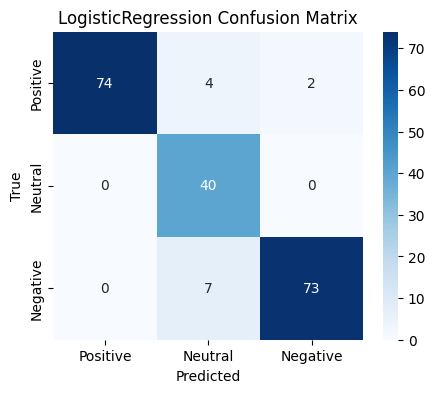

Evaluation of: MultinomialNB ==
Accuracy:  0.84
classification_report:                precision    recall  f1-score   support

    Negative      0.862     0.938     0.898        80
     Neutral      0.727     0.400     0.516        40
    Positive      0.846     0.963     0.901        80

    accuracy                          0.840       200
   macro avg      0.812     0.767     0.772       200
weighted avg      0.829     0.840     0.823       200



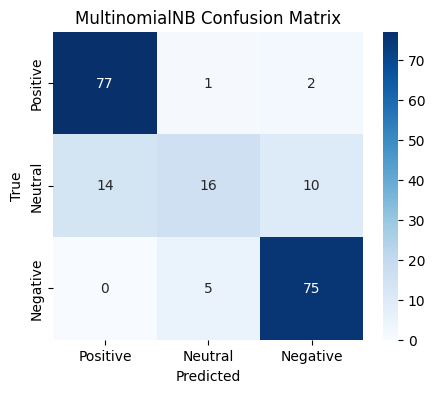

F1-macro: LR =  0.9273651080102693 , NB =  0.7716391401313577
Selected Model for Final Labeling:  LogisticRegression


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def rating_to_label(r):
    if r>=4:
        return "Positive"
    elif r <= 2:
        return "Negative"
    else: 
        return "Neutral"

df_reviews['Rating_label'] = df_reviews['Rating'].apply(rating_to_label)



print("Rating Label Distribution: ", df_reviews['Rating_label'].value_counts())


# --- 1. Choose text field for features ---
if 'Lemmas_NoStop' in df_reviews.columns:
    df_reviews["ModelText"] = df_reviews['Lemmas_NoStop'].apply(lambda x: " ".join(x))
        # .apply(): This is a Series method (a Series is a single column of a DataFrame) 
else:
    # fallback to cleaned text
    df_reviews['ModelText'] = df_reviews['CleanedText'].astype(str)

df_reviews.to_csv("Lemmatized_new.csv", index = False)



# --- 2. Train/test split ---
X = df_reviews['ModelText']
Y = df_reviews['Rating_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
'''
stratify = y
This is crucial! It ensures that the class balance is maintained in both sets. 
If 10% of your total reviews are "Negative," then X_train and X_test will also each have about 10% "Negative" reviews. 
It's like ensuring your Study Guide covers all topics that will be on the Final Exam.
'''

# --- 3. Feature Engineering ----

# Machine learning models cannot directly process raw text. 
# Text Vectorization is the process of converting text into numerical feature vectors.
# Term Frequency-Inverse Document Frequency (TF-IDF): A statistical measure that reflects how important a word is to a document in a collection or corpus.

# TF (Term Frequency): How often a word appears in a document.

# IDF (Inverse Document Frequency): A measure of how common or rare a word is across all documents (penalizes common words like "the" or "a").

# TF-IDF is the product of TF and IDF, giving more weight to words that are frequent in a specific document but rare across the entire dataset (i.e., highly discriminative words).

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df = 2, smooth_idf = True)

X_train_tfidf = tfidf.fit_transform(X_train) # Learn vocab/IDF from training data and transform it.
X_test_tfidf = tfidf.transform(X_test) # Apply learned vocab/IDF to transform the test data.


# ---- 4. Logistic Regression Starts ----

lr = LogisticRegression(max_iter = 1000, class_weight = 'balanced', random_state = 30)
lr.fit(X_train_tfidf, Y_train)
y_pred_lr = lr.predict(X_test_tfidf)


# ----5. Multinomial Naive Bayes ----
nb = MultinomialNB()
nb.fit(X_train_tfidf, Y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# ---- 5. Evaluate Models ----

def evaluate(y_true, y_pred, model_name = "Model"):
    print(f"Evaluation of: {model_name} ==")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("classification_report: ",classification_report(y_true, y_pred, digits = 3))
    cm = confusion_matrix(y_true, y_pred, labels = ["Positive", "Neutral", "Negative"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', xticklabels=["Positive","Neutral","Negative"], yticklabels=["Positive","Neutral","Negative"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate(Y_test, y_pred_lr, "LogisticRegression")
evaluate(Y_test, y_pred_nb, "MultinomialNB")


from sklearn.metrics import f1_score

lr_f1 = f1_score(Y_test, y_pred_lr, average = 'macro')
nb_f1 = f1_score(Y_test, y_pred_nb, average = 'macro')
print("F1-macro: LR = ", lr_f1, ", NB = ", nb_f1)

best_model = lr if lr_f1 >= nb_f1 else nb

best_name = "LogisticRegression" if lr_f1 >= nb_f1 else "MultinomialNB"
print("Selected Model for Final Labeling: ", best_name)

# --- Final Predictions on the entire dataset ---

X_full_tfidf = tfidf.transform(df_reviews['ModelText'])

df_reviews['Model_Label'] = best_model.predict(X_full_tfidf)


df_reviews.to_csv("Final Predictions.csv", index = False)


# 4. Exploratory Data Analysis of Sentiments:

### 4a: Analyze Sentiment Distribution

#### Load and Inspect

In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv("Final Predictions.csv")

# print(df)
print(df['Model_Label'].value_counts())

Model_Label
Positive    390
Negative    390
Neutral     220
Name: count, dtype: int64


#### Numeric Summary

In [11]:
print(df['Model_Label'].value_counts())
print()
sentiment_perc = df['Model_Label'].value_counts(normalize=True)*100
print(sentiment_perc)



Model_Label
Positive    390
Negative    390
Neutral     220
Name: count, dtype: int64

Model_Label
Positive    39.0
Negative    39.0
Neutral     22.0
Name: proportion, dtype: float64


#### Sentiment Count Plot & Sentiment percentage bar

C:\Users\hp\AppData\Local\Temp\ipykernel_12236\1565196179.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x = 'Model_Label', order = ['Positive', 'Neutral', 'Negative'], palette = 'viridis')
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `in

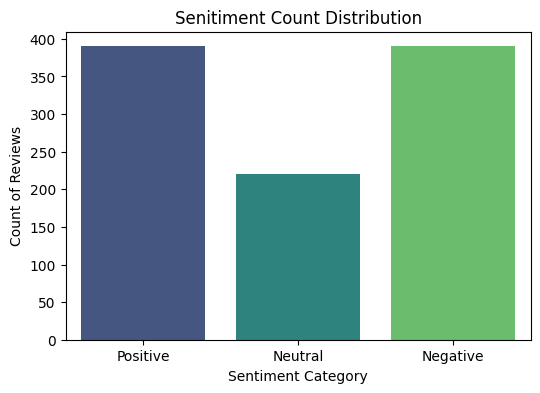

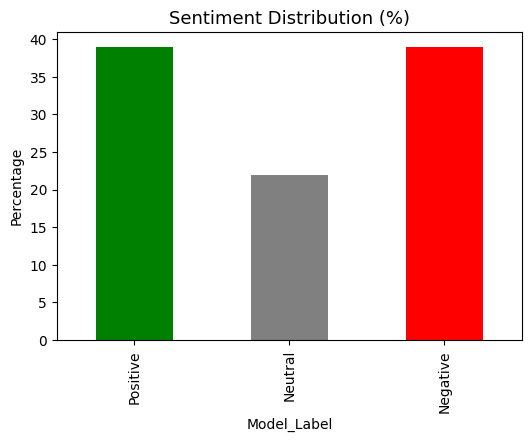

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
sns.countplot(data=df, x = 'Model_Label', order = ['Positive', 'Neutral', 'Negative'], palette = 'viridis')
plt.title("Senitiment Count Distribution")
plt.xlabel('Sentiment Category')
plt.ylabel("Count of Reviews")


plt.figure(figsize=(6,4))
(sentiment_perc
    .reindex(['Positive','Neutral','Negative'])
    .plot(kind='bar', color=['green','gray','red']))
plt.title('Sentiment Distribution (%)', fontsize=13)
plt.ylabel('Percentage')
plt.show()


#### Sentiment-by-Rating Analysis (Cross-Tabulation Heatmap)

##### 💡 Purpose: Validate whether your model aligns with human-given ratings (1-5 stars).
##### 💡 It checks model reliability and highlights misalignments (e.g., “positive” label but 1-star rating).

A heatmap of a cross-tabulation (crosstab) between:

Rows → ⭐ Actual user ratings (1 to 5 stars)

Columns → 🧠 Predicted sentiment label (Negative / Neutral / Positive)

Cell values → 📊 Percentage of reviews with that rating that received each predicted sentiment

In simpler terms:

👉 Each row adds up to ~100%.
Each cell tells you: “Out of all reviews rated X stars, what percentage were predicted as sentiment Y?”

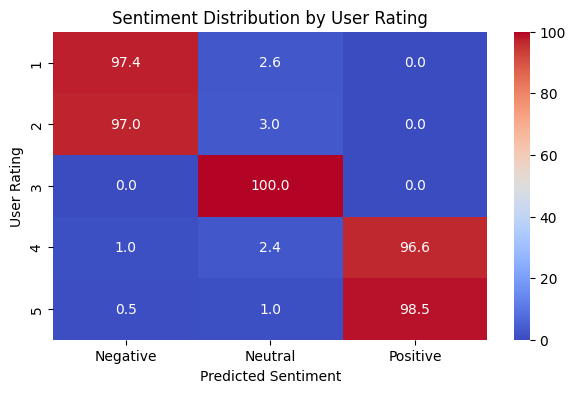

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize = (7,4))

cross_tabulation = pd.crosstab(df['Rating'], df['Model_Label'], normalize = 'index')*100
sns.heatmap(cross_tabulation, annot=True, cmap = 'coolwarm', fmt = '.1f')
plt.title("Sentiment Distribution by User Rating")
plt.xlabel('Predicted Sentiment')
plt.ylabel('User Rating')
plt.show()

#### Sentiment Correlation Matrix via Text Length & Rating

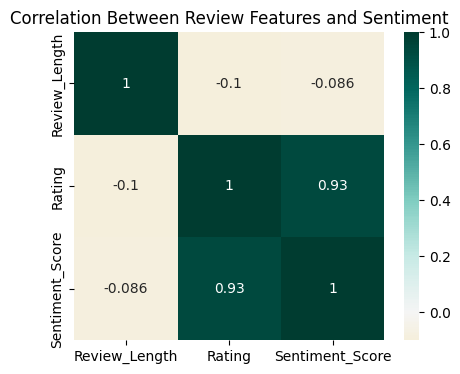

In [14]:
df['Review_Length'] = df['CleanedText'].apply(lambda x: len(str(x).split())) 
# iterates through every text entry in the CleanedText column, counts the number of words in that entry, and stores that word count

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Sentiment_Score'] = df['Model_Label'].map(sentiment_map)

# Compute Correlations
corr = df[['Review_Length', 'Rating', 'Sentiment_Score']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot = True, cmap = 'BrBG', center = 0)
plt.title('Correlation Between Review Features and Sentiment')
plt.show()

### 4b: Create word clouds for positive and negative reviews to identify prominent terms
####  Visualizing the most frequent words in positive and negative text reviews using Word Clouds,

In [17]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [19]:
df

,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate,CleanedText,Tokens,Tokens_NoStop,Lemmas_NoStop,Rating_label,ModelText,Model_Label,VADER_Label,TB_Label,Review_Length,Sentiment_Score
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,4/17/2023,fantastic wonderful experience,"['fantastic', 'wonderful', 'experience']","['fantastic', 'wonderful', 'experience']","['fantastic', 'wonderful', 'experience']",Positive,fantastic wonderful experience,Positive,Positive,Positive,3,1
1,REV2001,Product_C,User_186,2,broke easily.awful.,11/27/2023,broke easily awful,"['broke', 'easily', 'awful']","['broke', 'easily', 'awful']","['break', 'easily', 'awful']",Negative,break easily awful,Negative,Negative,Normal,3,-1
2,REV2002,Product_E,User_101,3,met expectations.five stars.,12/10/2023,met expectations five stars,"['met', 'expectations', 'five', 'stars']","['met', 'expectations', 'stars']","['meet', 'expectation', 'star']",Neutral,meet expectation star,Neutral,Neutral,Normal,4,0
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,11/10/2023,very satisfied wonderful experience,"['very', 'satisfied', 'wonderful', 'experience']","['satisfied', 'wonderful', 'experience']","['satisfied', 'wonderful', 'experience']",Positive,satisfied wonderful experience,Positive,Positive,Positive,4,1
4,REV2004,Product_C,User_158,1,worst purchase.one star.,5/25/2024,worst purchase one star,"['worst', 'purchase', 'one', 'star']","['worst', 'purchase', 'star']","['bad', 'purchase', 'star']",Negative,bad purchase star,Negative,Negative,Negative,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,REV2995,Product_D,User_133,3,average product.worst purchase.,12/10/2024,average product worst purchase,"['average', 'product', 'worst', 'purchase']","['average', 'product', 'worst', 'purchase']","['average', 'product', 'bad', 'purchase']",Neutral,average product bad purchase,Neutral,Neutral,Negative,4,0
996,REV2996,Product_B,User_143,3,met expectations.poor quality.,3/19/2023,met expectations poor quality,"['met', 'expectations', 'poor', 'quality']","['met', 'expectations', 'poor', 'quality']","['meet', 'expectation', 'poor', 'quality']",Neutral,meet expectation poor quality,Neutral,Neutral,Normal,4,0
997,REV2997,Product_C,User_185,3,works as expected.five stars.,3/15/2023,works as expected five stars,"['works', 'as', 'expected', 'five', 'stars']","['works', 'expected', 'stars']","['work', 'expect', 'star']",Neutral,work expect star,Neutral,Neutral,Normal,5,0
998,REV2998,Product_A,User_106,5,fantastic. excellent quality. neither good nor...,9/26/2023,fantastic excellent quality neither good nor bad,"['fantastic', 'excellent', 'quality', 'neither...","['fantastic', 'excellent', 'quality', 'neither...","['fantastic', 'excellent', 'quality', 'neither...",Positive,fantastic excellent quality neither good nor bad,Positive,Positive,Positive,7,1


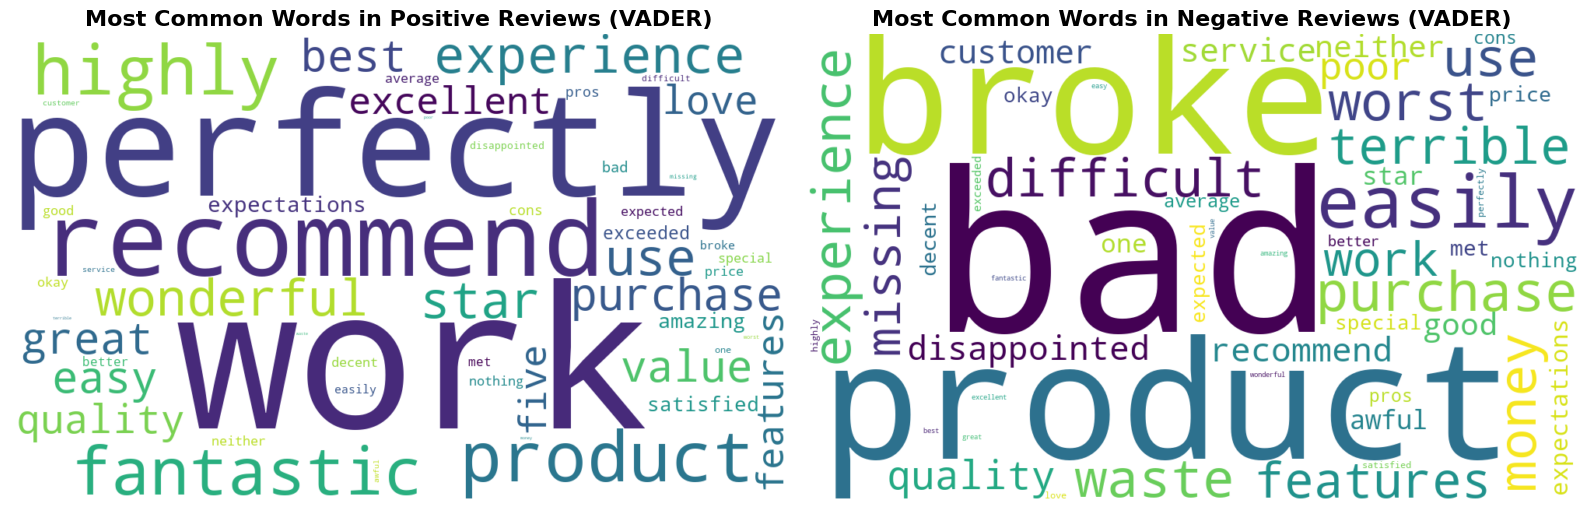

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = ' '.join(df[df['VADER_Label'] == 'Positive']['CleanedText'])
negative_reviews = ' '.join (df[df['VADER_Label'] == 'Negative']['CleanedText'])

wc_settings = {
    'width': 1000, 'height': 600, 'background_color': 'white', 'max_words': 150, 'collocations': False, 'colormap':'viridis',
}

wc_positive = WordCloud(**wc_settings).generate(positive_reviews)
wc_negative = WordCloud(**wc_settings).generate(negative_reviews)

# Keyword Argument Unpacking (∗∗)
# The ∗∗ operator tells Python to take a dictionary and treat its keys as parameter names and its values as the arguments for those parameters when calling a function

plt.figure(figsize = (16,8))

plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews (VADER)', fontsize=16, weight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews (VADER)', fontsize=16, weight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


#### Using ModelText (Lemmas_NoStop)

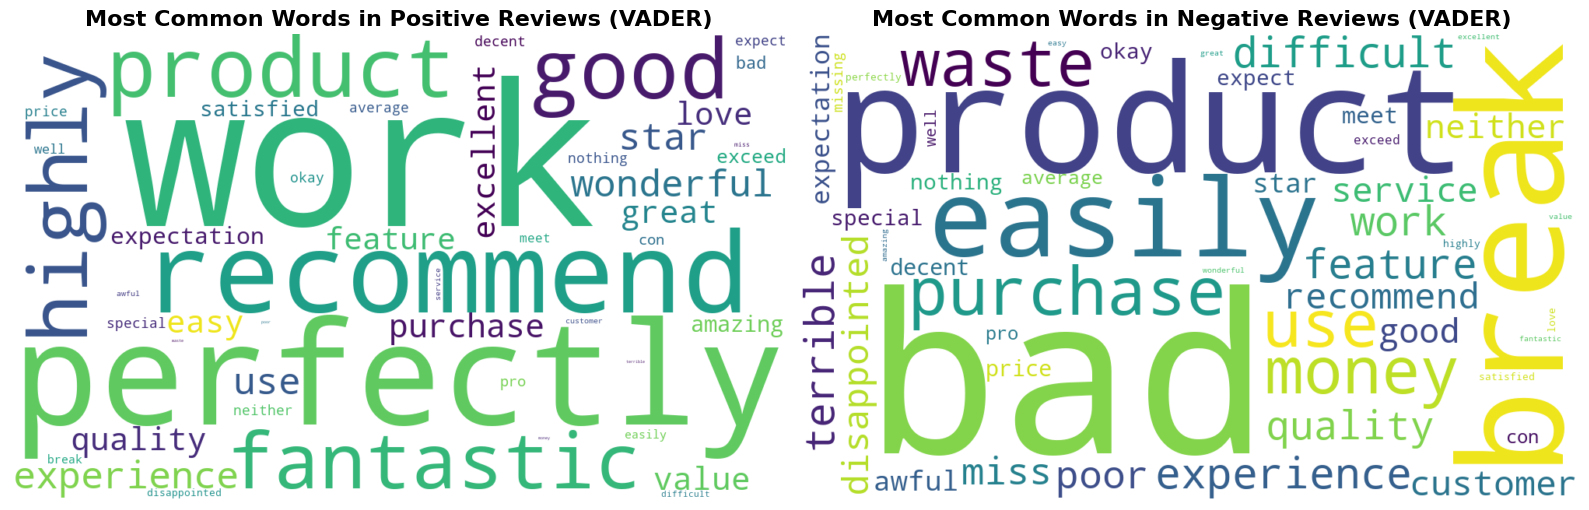

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_reviews = ' '.join(df[df['VADER_Label'] == 'Positive']['ModelText'])
negative_reviews = ' '.join (df[df['VADER_Label'] == 'Negative']['ModelText'])

wc_settings = {
    'width': 1000, 'height': 600, 'background_color': 'white', 'max_words': 150, 'collocations': False, 'colormap':'viridis',
}

wc_positive = WordCloud(**wc_settings).generate(positive_reviews)
wc_negative = WordCloud(**wc_settings).generate(negative_reviews)

# Keyword Argument Unpacking (∗∗)
# The ∗∗ operator tells Python to take a dictionary and treat its keys as parameter names and its values as the arguments for those parameters when calling a function

plt.figure(figsize = (16,8))

plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews (VADER)', fontsize=16, weight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews (VADER)', fontsize=16, weight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


In [35]:
df.to_csv("09Oct2025.csv")

### 4c. Examine sentiment trends by product (if applicable) or over time (if review dates are available).

#### The goal is to:

#### 1. Quantify how sentiment changes across products and/or time (monthly, weekly, etc.).

#### 2. Identify patterns, anomalies, or seasonal variations in user opinions.

#### The objective here is to see which products receive the most positive, negative, and neutral reviews, and rank them

#### The goal here is to track how the proportion (percentage) of Positive, Negative, and Neutral reviews changes from month to month, revealing trends, seasonal effects, or the impact of events.


Top 10 products by Positive Reviews


VADER_Label,Negative,Neutral,Positive
ProductID,,,
Product_A,55,49,100
Product_C,51,60,96
Product_E,53,44,87
Product_D,73,58,86
Product_B,56,51,81


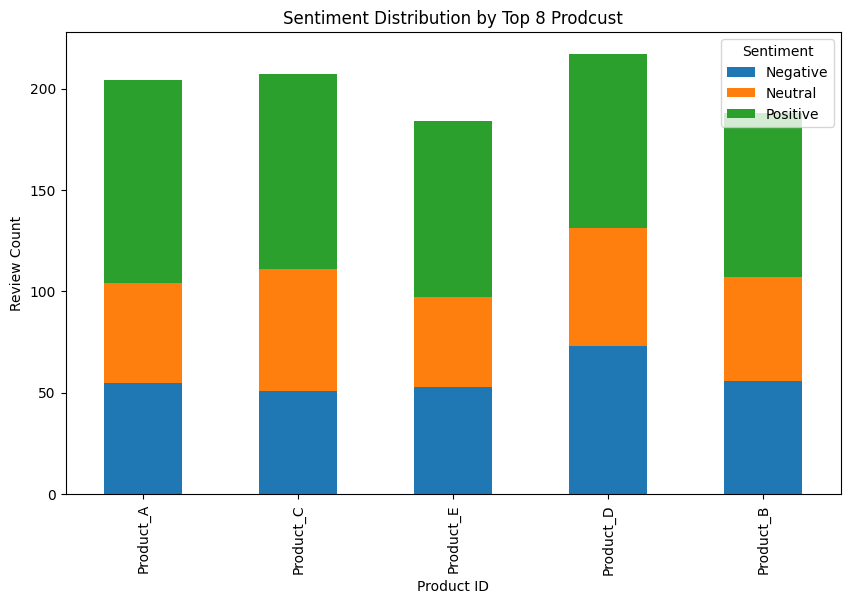


Monthly Sentiment Percentage Distribution:


,VADER_Label,Negative,Neutral,Positive
Month,Month,,,
2024-03,2024-03,30.000000,30.000000,40.000000
2024-04,2024-04,26.829268,21.951220,51.219512
2024-05,2024-05,25.531915,36.170213,38.297872
2024-06,2024-06,30.000000,42.500000,27.500000
2024-07,2024-07,33.333333,26.190476,40.476190
2024-08,2024-08,50.000000,26.666667,23.333333
2024-09,2024-09,30.000000,20.000000,50.000000
2024-10,2024-10,29.545455,15.909091,54.545455
2024-11,2024-11,29.729730,21.621622,48.648649


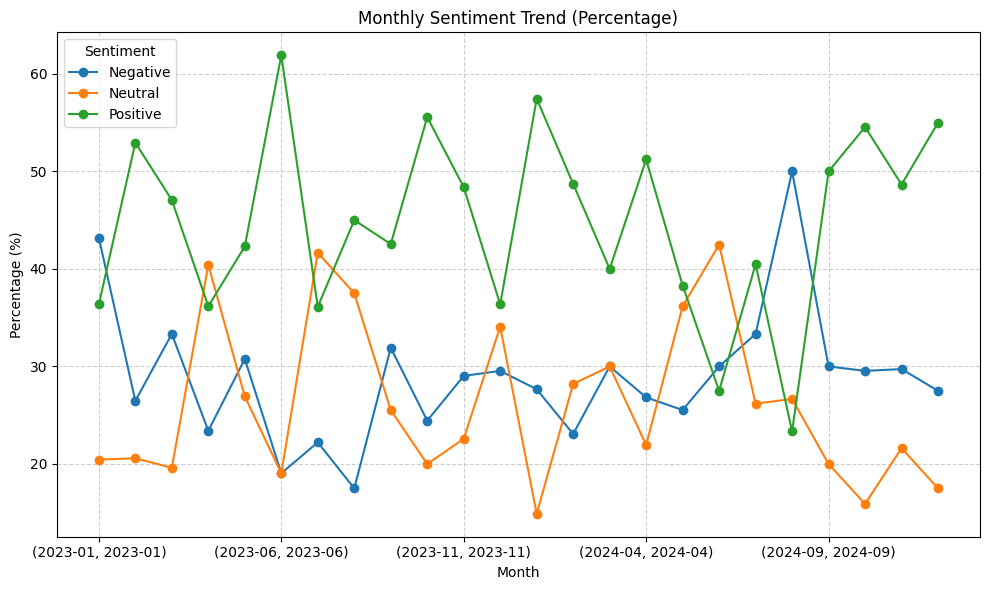

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def sentiment_trend_analysis(df, sentiment_col = "VADER_Label", date_col = "ReviewDate", product_col = "ProductID"):
    df[date_col] = pd.to_datetime(df[date_col], errors = 'coerce')
    df['Month'] = df[date_col].dt.to_period('M').astype(str)

    product_sentiment = (
        df.groupby([product_col, sentiment_col])
        .size()
        .unstack(fill_value = 0)
        .sort_values(by = 'Positive', ascending = False)
        )
    
    print("Top 10 products by Positive Reviews")
    display(product_sentiment.head(10))

    top_products = product_sentiment.head(8)
    top_products.plot(kind = 'bar', stacked = True, figsize = (10,6))
    plt.title("Sentiment Distribution by Top 8 Prodcust")
    plt.xlabel('Product ID')
    plt.ylabel('Review Count')
    plt.legend(title = 'Sentiment')
    plt.show()

    # --- Sentiment Trends Over Time ---
    time_sentiment = (
        df.groupby(['Month', sentiment_col])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum() * 100) # Instead of raw counts, it calculates the percentage of Positive, Negative, and Neutral reviews out of the total reviews for that month
        .unstack(fill_value=0)
    )

    print("\nMonthly Sentiment Percentage Distribution:")
    display(time_sentiment.tail(10))

    # Plot time-based sentiment trend
    time_sentiment.plot(kind='line', marker='o', figsize=(10, 6))
    plt.title('Monthly Sentiment Trend (Percentage)')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Month')
    plt.legend(title='Sentiment')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return product_sentiment, time_sentiment


# Example usage:
product_sentiment, time_sentiment = sentiment_trend_analysis(df, sentiment_col='VADER_Label')





# 5. Topic Modeling 

#### LDA (Latent Dirichlet Allocation) — probabilistic, interpretable, suited for longer text.

#### NMF (Non-negative Matrix Factorization) — linear algebra–based, often works better with TF-IDF and short texts like reviews.

#### Reverse-engineering the customer experience — identifying pain points without manual labeling.

##### Topic modeling pushes you from surface analysis (positive/negative) to root cause discovery.

##### Now you’re not just asking “What’s the sentiment?”, but “What’s driving the sentiment?”

##### Applying to Negative Reviews Only

Running LDA on 288 negative reviews....


Top 10 keywords per topic (LDA):

Topic 1 : recommend, bad, disappointed, experience, poor, quality, awful, okay, pro, good
Topic 2 : service, customer, bad, expectation, meet, price, decent, disappointed, missing, amazing
Topic 3 : product, bad, easily, break, terrible, work, purchase, experience, expect, average
Topic 4 : money, waste, quality, poor, bad, purchase, good, love, perfectly, star
Topic 5 : use, difficult, feature, miss, bad, good, star, purchase, exceed, awful


C:\Users\hp\AppData\Local\Temp\ipykernel_12236\3483514634.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index + 1, y=topic_counts.values, palette="viridis")
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to excl

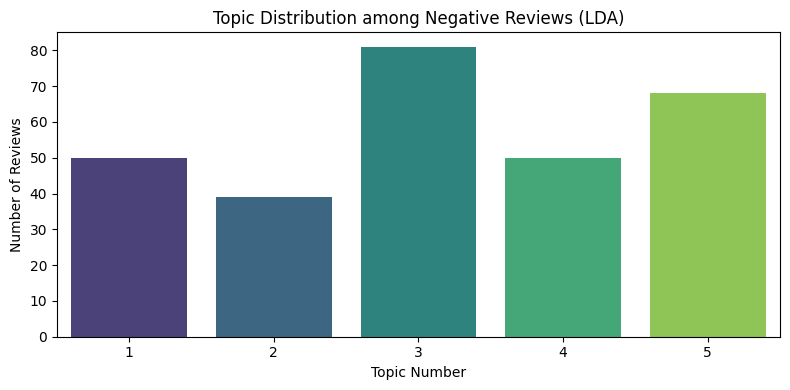

Running NMF on 288 negative reviews....


Top 10 keywords per topic (NMF):

Topic 1 : bad, experience, purchase, quality, poor, customer, service, work, good, recommend
Topic 2 : break, easily, work, awful, disappointed, experience, star, special, expect, miss
Topic 3 : difficult, use, feature, miss, good, work, missing, expect, bad, easy
Topic 4 : product, terrible, average, purchase, bad, customer, service, pro, love, meet
Topic 5 : waste, money, miss, feature, disappointed, awful, recommend, purchase, price, decent


C:\Users\hp\AppData\Local\Temp\ipykernel_12236\3483514634.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index + 1, y=topic_counts.values, palette="viridis")
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to excl

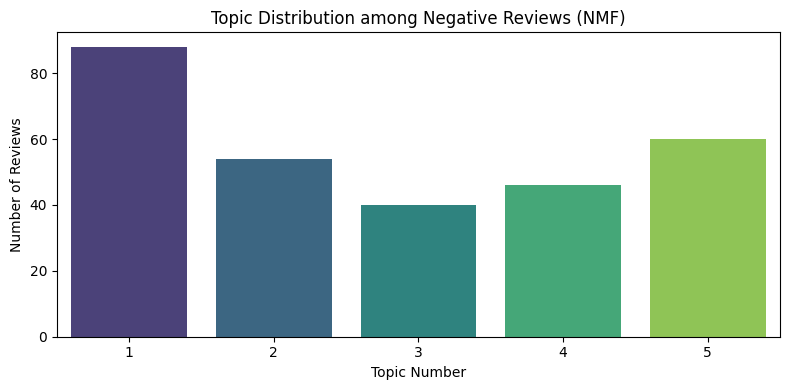

(NMF(n_components=5, random_state=42),
 TfidfVectorizer(max_features=1000, stop_words='english'))

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns

def display_topics(model, feature_names, n_top_words = 10, topic_type = "LDA"):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[: -n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1} : {', '.join(top_features)}")

def run_topic_modeling(df, text_col = 'ModelText', sentiment_col = "VADER_Label", model_type = 'LDA', n_topics = 5, n_top_words = 10, max_features = 1000):
    neg_reviews = df[df[sentiment_col] == "Negative"][text_col].dropna()
    print(f"Running {model_type} on {len (neg_reviews)} negative reviews....\n")

    if model_type.upper() == 'LDA':
        vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
        X = vectorizer.fit_transform(neg_reviews)
        model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    else: #NMF
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words = 'english')
        X = vectorizer.fit_transform(neg_reviews)
        model = NMF(n_components=n_topics, random_state=42)

    model.fit(X) 

    # --- Display Topics ---
    print(f"\nTop {n_top_words} keywords per topic ({model_type}):\n")
    display_topics(model, vectorizer.get_feature_names_out(), n_top_words, model_type)

    # --- Visualize Topic Distribution ---
    topic_distribution = model.transform(X)
    topic_counts = pd.Series(topic_distribution.argmax(axis=1)).value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    sns.barplot(x=topic_counts.index + 1, y=topic_counts.values, palette="viridis")
    plt.title(f"Topic Distribution among Negative Reviews ({model_type})")
    plt.xlabel("Topic Number")
    plt.ylabel("Number of Reviews")
    plt.tight_layout()
    plt.show()

    return model, vectorizer

    print(f"\nTop {n_top_words} keywords per topic ({model_type}):\n")
    display_topics(model, vectorizer.get_feature_names_out(), n_top_words, model_type)

run_topic_modeling(df, model_type = 'LDA', n_topics = 5)
run_topic_modeling(df, model_type = 'NMF', n_topics = 5)


# 6. Reporting

In [25]:
import pandas as pd
from collections import Counter

# Load your data
df = pd.read_csv("09Oct2025.csv")

# --- Sentiment distribution ---
sentiment_counts = df['Model_Label'].value_counts()
sentiment_percentages = round((sentiment_counts / len(df)) * 100, 2)
print("Sentiment Distribution (%):")
print(sentiment_percentages)

# --- Average sentiment score (from VADER or custom score) ---
avg_sentiment = df['Sentiment_Score'].mean()
print("\nAverage Sentiment Score:", round(avg_sentiment, 3))

# --- Common keywords in negative reviews ---
from sklearn.feature_extraction.text import CountVectorizer

neg_texts = df[df['Model_Label'] == 'Negative']['CleanedText']
cv = CountVectorizer(stop_words='english', max_features=20)
word_freq = cv.fit_transform(neg_texts)
common_words = pd.DataFrame({'Word': cv.get_feature_names_out(),
                             'Count': word_freq.toarray().sum(axis=0)}).sort_values('Count', ascending=False)

print("\nTop Negative Words:")
print(common_words)

# --- Group by ProductID to find most complained-about products ---
if 'ProductID' in df.columns:
    neg_by_product = df[df['Model_Label'] == 'Negative'].groupby('ProductID').size().sort_values(ascending=False).head(5)
    print("\nTop 5 Products with Most Negative Reviews:")
    print(neg_by_product)


Sentiment Distribution (%):
Model_Label
Positive    39.0
Negative    39.0
Neutral     22.0
Name: count, dtype: float64

Average Sentiment Score: 0.0

Top Negative Words:
            Word  Count
1            bad    110
12       product     63
19         worst     62
13      purchase     62
14     recommend     60
18         waste     58
17           use     58
10         money     58
6         easily     58
4      difficult     58
2          broke     58
7     experience     57
8       features     55
9        missing     55
5   disappointed     55
16          star     55
15       service     53
3       customer     53
0          awful     53
11          poor     51

Top 5 Products with Most Negative Reviews:
ProductID
Product_D    98
Product_C    75
Product_A    73
Product_B    72
Product_E    72
dtype: int64
